In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

trades = pd.read_csv("data/historical_data.csv")
sent = pd.read_csv("data/fear_greed_index.csv")

trades.head(), sent.head()

(                                      Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
 4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   
 
    Closed PnL                                   Transaction Hash     Order ID  \
 0      

In [30]:
def doc_df(df, name):
    print(f"=== {name} ===")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Missing values:\n", df.isnull().sum())
    print("Duplicate rows:", df.duplicated().sum())
    print()

doc_df(trades, "Trader Data")
doc_df(sent, "Sentiment Data")

=== Trader Data ===
Shape: (211224, 16)
Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
Missing values:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
Duplicate rows: 0

=== Sentiment Data ===
Shape: (2644, 4)
Columns: ['timestamp', 'value', 'classification', 'date']
Missing values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64
Duplicate rows: 0



## Data Overview and Quality Check

### Trader Dataset
The trader dataset contains 211,224 rows and multiple trading-related columns such as account, symbol, execution price, trade size (USD), side, closed PnL, and timestamps.

There are no missing values detected across columns.
No duplicate rows were found in the dataset.

### Sentiment Dataset
The sentiment dataset contains 2,644 rows with daily Bitcoin Fear & Greed index values.

Columns include:
- timestamp
- value (index score)
- classification (Fear, Greed, etc.)
- date

There are no missing values and no duplicate rows in this dataset.

Overall, both datasets are clean and suitable for further analysis.

## Sentiment date

In [31]:
sent["date"] = pd.to_datetime(sent["date"], errors="coerce").dt.date

## Trades date

In [32]:
trades["timestamp_ist"] = pd.to_datetime(trades["Timestamp IST"], dayfirst=True, errors="coerce")

# fallback using epoch if needed
bad = trades["timestamp_ist"].isna()
if bad.any():
    trades.loc[bad, "timestamp_ist"] = pd.to_datetime(trades.loc[bad, "Timestamp"], unit="ms", errors="coerce")

trades["date"] = trades["timestamp_ist"].dt.date

In [33]:
trades[["Timestamp IST","timestamp_ist","date"]].head()

,Timestamp IST,timestamp_ist,date
0,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02
1,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02
2,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02
3,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02
4,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02


In [34]:
trades = trades.rename(columns={
    "Account":"account",
    "Coin":"symbol",
    "Execution Price":"execution_price",
    "Size Tokens":"size_tokens",
    "Size USD":"size_usd",
    "Side":"side",
    "Closed PnL":"closed_pnl",
    "Fee":"fee",
})

In [35]:
def bucket_sentiment(x):
    x = str(x).lower()
    if "fear" in x:
        return "Fear"
    if "greed" in x:
        return "Greed"
    if "neutral" in x:
        return "Neutral"
    return "Other"

sent["sentiment_bucket"] = sent["classification"].apply(bucket_sentiment)
sent[["date","classification","sentiment_bucket"]].head()

,date,classification,sentiment_bucket
0,2018-02-01,Fear,Fear
1,2018-02-02,Extreme Fear,Fear
2,2018-02-03,Fear,Fear
3,2018-02-04,Extreme Fear,Fear
4,2018-02-05,Extreme Fear,Fear


In [36]:
merged = trades.merge(
    sent[["date","value","classification","sentiment_bucket"]],
    on="date",
    how="left"
)

merged[["account","symbol","size_usd","closed_pnl","date","sentiment_bucket"]].head()

,account,symbol,size_usd,closed_pnl,date,sentiment_bucket
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7872.16,0.0,2024-12-02,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,127.68,0.0,2024-12-02,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,1150.63,0.0,2024-12-02,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,1142.04,0.0,2024-12-02,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,69.75,0.0,2024-12-02,Greed


In [37]:
merged["sentiment_bucket"].isna().sum()

np.int64(6)

Add helper columns

In [38]:
merged["is_win"] = merged["closed_pnl"] > 0
merged["is_long"] = merged["side"].astype(str).str.upper().isin(["BUY","LONG"])
merged["is_short"] = merged["side"].astype(str).str.upper().isin(["SELL","SHORT"])

## Daily metrics per account

In [39]:
daily = (merged
         .groupby(["account","date","sentiment_bucket"], dropna=False)
         .agg(
             daily_pnl=("closed_pnl","sum"),
             trades=("closed_pnl","size"),
             win_rate=("is_win","mean"),
             avg_trade_size_usd=("size_usd","mean"),
             total_volume_usd=("size_usd","sum"),
             long_trades=("is_long","sum"),
             short_trades=("is_short","sum"),
         )
         .reset_index())

daily["long_short_ratio"] = daily["long_trades"] / daily["short_trades"].replace({0: np.nan})
daily.head()

,account,date,sentiment_bucket,daily_pnl,trades,win_rate,avg_trade_size_usd,total_volume_usd,long_trades,short_trades,long_short_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,Greed,0.0,177,0.000000,5089.718249,900880.13,0,177,0.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,Greed,0.0,68,0.000000,7976.664412,542413.18,0,68,0.0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,Greed,0.0,40,0.000000,23734.500000,949380.00,0,40,0.0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,Greed,-21227.0,12,0.000000,28186.666667,338240.00,12,0,NaN
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,Greed,1603.1,27,0.444444,17248.148148,465700.00,12,15,0.8


## Question 1 : Performance differs on Fear vs Greed?

In [40]:
fg = daily[daily["sentiment_bucket"].isin(["Fear","Greed"])].copy()

summary = (fg.groupby("sentiment_bucket")
           .agg(
               avg_daily_pnl=("daily_pnl","mean"),
               median_daily_pnl=("daily_pnl","median"),
               pnl_volatility=("daily_pnl","std"),
               avg_win_rate=("win_rate","mean"),
               avg_trades_per_day=("trades","mean"),
               avg_trade_size_usd=("avg_trade_size_usd","mean"),
           )
           .reset_index())

summary

,sentiment_bucket,avg_daily_pnl,median_daily_pnl,pnl_volatility,avg_win_rate,avg_trades_per_day,avg_trade_size_usd
0,Fear,5185.146443,122.737038,31224.148764,0.357071,105.363291,8529.859802
1,Greed,4144.208334,265.247725,29252.037677,0.362748,76.912266,5954.632633


## Chart 1 : Avg daily pnl

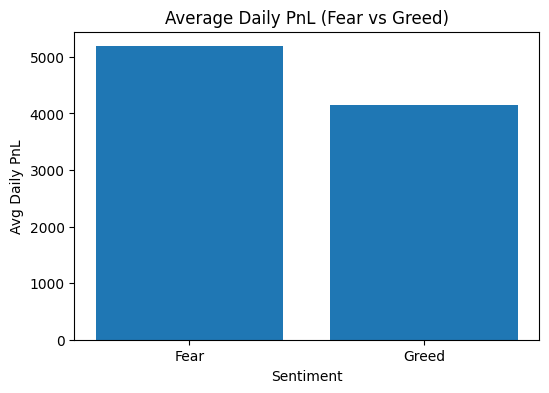

In [41]:
plt.figure(figsize=(6,4))
plt.bar(summary["sentiment_bucket"], summary["avg_daily_pnl"])
plt.title("Average Daily PnL (Fear vs Greed)")
plt.xlabel("Sentiment")
plt.ylabel("Avg Daily PnL")
plt.savefig("outputs/charts/chart1.png", dpi=300)
plt.show()

## Chart 2 : trades/day 

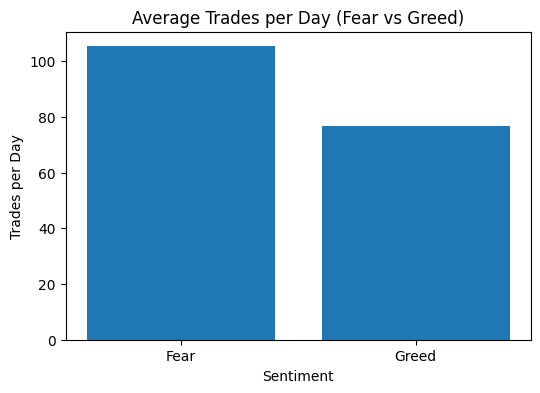

In [42]:
plt.figure(figsize=(6,4))
plt.bar(summary["sentiment_bucket"], summary["avg_trades_per_day"])
plt.title("Average Trades per Day (Fear vs Greed)")
plt.xlabel("Sentiment")
plt.ylabel("Trades per Day")
plt.savefig("outputs/charts/chart2.png", dpi=300)
plt.show()

## Chart 3: Distribution (boxplot)

C:\Users\patel\AppData\Local\Temp\ipykernel_11240\998824905.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([fear_pnl, greed_pnl], labels=["Fear","Greed"], showfliers=False)


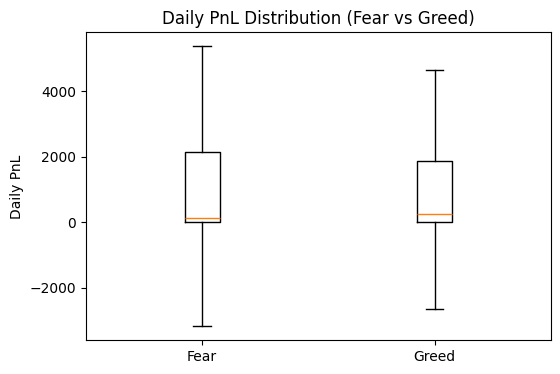

In [43]:
fear_pnl = fg[fg["sentiment_bucket"]=="Fear"]["daily_pnl"].dropna()
greed_pnl = fg[fg["sentiment_bucket"]=="Greed"]["daily_pnl"].dropna()

plt.figure(figsize=(6,4))
plt.boxplot([fear_pnl, greed_pnl], labels=["Fear","Greed"], showfliers=False)
plt.title("Daily PnL Distribution (Fear vs Greed)")
plt.ylabel("Daily PnL")
plt.savefig("outputs/charts/chart3.png", dpi=300)
plt.show()

## Question 2 : Behavior Changes ? 

In [44]:
behavior = (fg.groupby("sentiment_bucket")
            .agg(
                avg_trades=("trades","mean"),
                avg_size=("avg_trade_size_usd","mean"),
                avg_long_short=("long_short_ratio","mean"),
            )
            .reset_index())
behavior

,sentiment_bucket,avg_trades,avg_size,avg_long_short
0,Fear,105.363291,8529.859802,2.235176
1,Greed,76.912266,5954.632633,1.634119


## Question 3 : Identify 2–3 segments

In [45]:
total_trades = merged.groupby("account").size()
cut = total_trades.median()

seg = pd.DataFrame({
    "account": total_trades.index,
    "freq_segment": np.where(total_trades.values >= cut, "Frequent", "Infrequent")
})

fg_seg = fg.merge(seg, on="account", how="left")

In [46]:
seg_summary = (fg_seg.groupby(["sentiment_bucket","freq_segment"])
               .agg(avg_daily_pnl=("daily_pnl","mean"),
                    avg_win_rate=("win_rate","mean"),
                    avg_trades=("trades","mean"))
               .reset_index())
seg_summary

,sentiment_bucket,freq_segment,avg_daily_pnl,avg_win_rate,avg_trades
0,Fear,Frequent,5968.410192,0.372596,126.113043
1,Fear,Infrequent,3090.371301,0.315550,49.869767
2,Greed,Frequent,3846.861070,0.375650,92.747696
3,Greed,Infrequent,4987.663970,0.326148,31.993464


# Part C — Actionable Strategy Ideas

## Strategy 1 — Risk Control During Fear Periods

Observation:
- Traders increase frequency and position size during Fear days.
- PnL volatility is higher in Fear regimes.

Actionable Rule:
- For lower win-rate traders, limit daily trade count.
- Cap position size during Fear periods.
- Implement tighter drawdown thresholds.

Rationale:
Fear environments appear to increase reactive trading behavior and volatility exposure.

---

## Strategy 2 — Selective Scaling During Greed Periods

Observation:
- Win rates are similar across regimes.
- Greed days show lower volatility and lower trade frequency.

Actionable Rule:
- Allow higher win-rate traders to moderately increase position size.
- Maintain stricter controls for lower win-rate traders.
- Focus on quality trades rather than increasing frequency.

Rationale:
Sentiment impacts behavior more than trade accuracy; scaling should depend on trader quality, not market mood alone.

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Prepare model dataset
model_df = daily.copy()
model_df = model_df.sort_values(["account","date"])

# Create next-day label
model_df["next_day_pnl"] = model_df.groupby("account")["daily_pnl"].shift(-1)
model_df["y_next_positive"] = (model_df["next_day_pnl"] > 0).astype(int)

# Features
num_cols = ["trades","avg_trade_size_usd","total_volume_usd"]
cat_cols = ["sentiment_bucket"]

model_ready = model_df.dropna(subset=num_cols + cat_cols + ["y_next_positive"])

X = model_ready[num_cols + cat_cols]
y = model_ready["y_next_positive"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing
preprocess = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

clf = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

# Train
clf.fit(X_train, y_train)

# Evaluate
pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, pred))
print("ROC-AUC:", roc_auc_score(y_test, proba))

Accuracy: 0.6217948717948718
ROC-AUC: 0.6251965752227853


## Bonus Model Explanation

A logistic regression model was built to predict whether next-day PnL would be positive.

Features used:
- Trade frequency
- Average trade size
- Total volume
- Sentiment bucket

The model provides baseline predictive power and demonstrates that behavioral features combined with sentiment contain signal for short-term profitability forecasting.

Note: This is a simple baseline model and not optimized for production use.